# Wood moisture classification (wmc) model creation pipeline

The following code is adapted from the FP-AI-SENSING1 application of ST microelectronics

In [1]:
import numpy as np
import os
from tqdm import tqdm
import librosa
import librosa.display
import librosa.util
from IPython.display import Audio
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.utils
from keras import layers
from keras import models
from keras import optimizers
from pickle import dump
import random

In [2]:
# Current version (for reproduction)
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("Librosa:", librosa.__version__)

TensorFlow: 2.4.1
Keras: 2.4.3
Librosa: 0.8.1


## Global settings
__Important:__ These settings have to match the ones in the STM32 application.

In [3]:
AUDIO_SAMPLING_FREQUENCY = 48000 # kHz 
NB_FFTS = 32 # How many columns for the short time fourier transformation
NB_BINS = 30 # Resolution (bins) of one STFT column
HOP_LENGTH = 512 # Jumps between FFT windows
FRAME_SIZE = HOP_LENGTH*NB_FFTS + HOP_LENGTH # For one spectrogram column 1024 samples are needed
NB_FRAMES = 100 # Total number of frames recorded in one WAV file
FFT_SIZE = 1024 # Size for one FFT
FREQ_MIN = 5000 # Lowest bin for the columns
TOP_DB = 80 # Cut off of DBs

## 1. Import and convert the data
Load the files from the data directory. The labels for the files are specified in model/dataset/labels.txt.

In [4]:
dataset_dir = './dataset'
fileset_path = path = os.path.join(dataset_dir, 'labels.txt')
fileset = np.loadtxt(fileset_path, dtype=str)

# 3 classes : 0 dry, 1 semiwet, 2 wet
class_names = ['dry', 'semiwet', 'wet']
labels = {
    'dry' : 0,
    'semiwet' : 1,
    'wet' : 2,
}


# x is a list of the recordings and y is a list of the respective labels (targets)
x = []
y = []

# Iteratate over all recordings defined in labels.txt
for file in tqdm(fileset):
    file_path, file_label = file
    file_path = os.path.join(dataset_dir, file_path)
    
    signal, _ = librosa.load(file_path, sr=AUDIO_SAMPLING_FREQUENCY, mono=True, dtype=np.float32)   
    # Cut off total samples because recording takes a bit more samples
    signal = signal[0:NB_FRAMES*FRAME_SIZE]
    
    label = labels[file_label]
    
    x.append(signal)
    y.append(label)

100%|██████████| 18/18 [00:00<00:00, 91.34it/s]


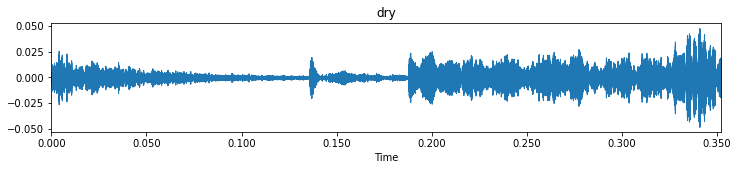

In [5]:
# Check a random sample of first recording
rand = random.randint(0, NB_FRAMES)
recording1 = x[1]
frame = recording1[FRAME_SIZE*rand:FRAME_SIZE*(rand+1)]

plt.figure(figsize=(12, 2))
plt.title(class_names[y[1]])
librosa.display.waveplot(frame, sr=AUDIO_SAMPLING_FREQUENCY)
Audio(frame, rate=AUDIO_SAMPLING_FREQUENCY)

## 2. Prepare the data

### 2.1 Slice data into random frames
Each audio recording (WAV file) contains the specified number of frames (NB_FRAMES).

Each frame will contain 16,896 samples (32 * 512 + 512) to create a 32 column spectrogram with FFT_SIZE=1024 and HOP_LENGTH=512.

In [6]:
# Each frame will now be an entry in the list
x_framed = []
y_framed = []

# Iteratate over all recordings and create frames


for i in range(len(x)):
    x_tmp = np.asarray(x[i])    
    for k  in range(NB_FRAMES):
        frame = x_tmp[k*FRAME_SIZE:(k+1)*FRAME_SIZE]
        x_framed.append(np.transpose(frame)) 
    y_framed.append(np.full(NB_FRAMES, y[i]))
    
# Convert into numpy arrays
x_framed = np.asarray(x_framed)
y_framed = np.asarray(y_framed)

# Reshape labels 
y_framed = y_framed.reshape(y_framed.shape[0]*y_framed.shape[1], )

print("x_framed shape: ", x_framed.shape) # Each frame of 16,896 samples can be used to create a spectrogram 
print("y_framed shape: ", y_framed.shape) # Corresponding label for each frame


x_framed shape:  (1800, 16896)
y_framed shape:  (1800,)


### 2.2 Preprocess the data into STFT spectrograms
Frames are transformed into the spectrograms of size NB_BINS*NB_FFTS. A filter bank is created for the FFT columns. The filter bank has to match the one used in the microcontroller.

In [7]:
# Initalize FilterBank for the linear FFT bins
FilterStartIndices = []
FilterStopIndices = []

def FilterBankInit():
    start_idx = 107;
    
    for i in range(NB_BINS):
        FilterStartIndices.append(start_idx);
        
        freq_bin = 5300 + i * 600;

        for j in range(start_idx,int(FFT_SIZE/2+1)):
            fft_freq = 48000 / 1024 * j;

            if (abs(freq_bin-fft_freq) > 300):
                start_idx = j;
                FilterStopIndices.append(j)
                break;

FilterBankInit()
print(FilterStartIndices)
print(FilterStopIndices)

def FilterBank(STFT):
    S = np.zeros((NB_BINS, 32))
    for i in range(NB_BINS):
        start_idx = FilterStartIndices[i]
        stop_idx = FilterStopIndices[i]

        for k in range(32):
            sum = 0
            for j in range(start_idx, stop_idx):
                sum += STFT[j,k];

            S[i, k] = sum;
    return S

[107, 120, 133, 146, 158, 171, 184, 197, 210, 222, 235, 248, 261, 274, 286, 299, 312, 325, 338, 350, 363, 376, 389, 402, 414, 427, 440, 453, 466, 478]
[120, 133, 146, 158, 171, 184, 197, 210, 222, 235, 248, 261, 274, 286, 299, 312, 325, 338, 350, 363, 376, 389, 402, 414, 427, 440, 453, 466, 478, 491]


In [8]:
# Spectograms of frames which will be the feautures for the neural network
x_features = []
y_features = y_framed

for frame in tqdm(x_framed):
    # Create a STFT spectrogram
    STFT = np.abs(librosa.stft(y=frame, n_fft=1024, hop_length=HOP_LENGTH, window='hann', center=False, dtype=None))
    S = FilterBank(STFT) # Why 513 values????

    
    # Scale according to reference power
    S = S / S.max()
    # Convert to dB
    S_log = librosa.power_to_db(S, top_db=TOP_DB)
    x_features.append(S_log)


# Convert into numpy array
x_features = np.asarray(x_features)

print("x_features shape: ", x_features.shape)

100%|██████████| 1800/1800 [00:16<00:00, 111.20it/s]

x_features shape:  (1800, 30, 32)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners

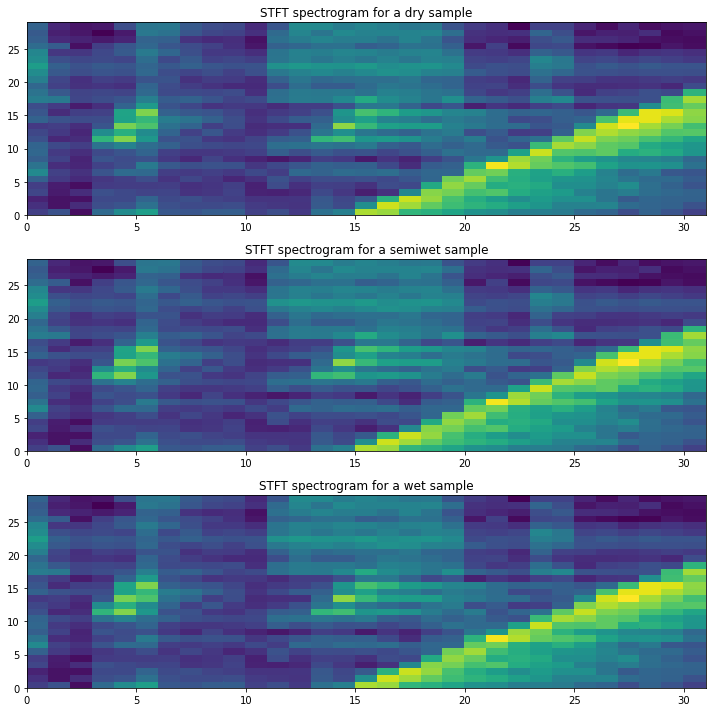

In [10]:
# Plot spectrogram generated for each feature class

# Create grid
grid_x, grid_y = np.mgrid[:32, :30]

plt.figure(figsize=(10, 10))

plt.subplot(311)
first_index = np.argmax(y_framed == 0)
z = x_features[first_index, :, :]
z = z.transpose()
plt.pcolormesh(grid_x, grid_y, z)
plt.title('STFT spectrogram for a ' + class_names[y_features[first_index]] + ' sample')

plt.subplot(312)
second_index = np.argmax(y_framed == 1)
z = x_features[first_index, :, :]
z = z.transpose()
plt.pcolormesh(grid_x, grid_y, z)
plt.title('STFT spectrogram for a ' + class_names[y_features[second_index]] + ' sample')

plt.subplot(313)
third_index = np.argmax(y_framed == 2)
z = x_features[first_index, :, :]
z = z.transpose()
plt.pcolormesh(grid_x, grid_y, z)
plt.title('STFT spectrogram for a ' + class_names[y_features[third_index]] + ' sample')

plt.tight_layout()
plt.show()

### 2.3 Normalize features
Normalize features by removing the mean and scaling to unit variance. Save the feature scalers to model/normalize.

In [11]:
# Flatten features for scaling
x_features_r = np.reshape(x_features, (len(x_features), NB_BINS * NB_FFTS))

# Create a feature scaler
scaler = preprocessing.StandardScaler().fit(x_features_r)
mean = scaler.mean_
std = scaler.scale_

#  Save feature scaler
normalize_dir = './normalize/'
np.savetxt(normalize_dir + 'mean.csv', mean.reshape(240, 4),  fmt='%.10e', delimiter=",", newline=",\n")
np.savetxt( normalize_dir + 'std.csv', std.reshape(240, 4),  fmt='%.10e', delimiter=",", newline=",\n")
dump(scaler, open(normalize_dir + 'scaler.pkl', 'wb'))

# Apply the feature scaler 
x_features_s = scaler.transform(x_features_r)

print("x_features_s shape: ", x_features_s.shape)

x_features_s shape:  (1800, 960)


### 2.4 One hot encoding of labels
Keras requires one hot encoded labels.

In [12]:
# Convert labels to categorical one-hot encoding
y_features_hot = tf.keras.utils.to_categorical(y_features, num_classes=len(class_names))

print('The shape of the one-hot encoded labels np array is: ' , y_features_hot.shape)

The shape of the one-hot encoded labels np array is:  (1800, 3)


### 2.5 Split data into training, validation and test
Use 25% for testing. The remaining 75% of the features are split in 25% for validation and 75% for training.

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_features_s,
                                                    y_features_hot,
                                                    test_size=0.25,
                                                    random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  random_state=1)

print('Training samples:', x_train.shape)
print('Validation samples:', x_val.shape)
print('Test samples:', x_test.shape)

Training samples: (1012, 960)
Validation samples: (338, 960)
Test samples: (450, 960)


### 2.6 (Optional) Save the features
Save the features to a csv file in a format X-CUBE-AI can understand, that is, for each tensor, the values are in a flattened vector.

In [14]:
#val_dir = './validation/'
#np.savetxt(val_dir + 'x_train.csv', x_train.reshape(len(x_train), n_mels*n_stft_columns), delimiter=",")
#np.savetxt(val_dir + 'y_train.csv', y_train, delimiter=",")
#np.savetxt(val_dir + 'x_val.csv', x_val.reshape(len(x_val), n_mels*n_stft_columns), delimiter=",")
#np.savetxt(val_dir + 'y_val.csv', y_val, delimiter=",")
#np.savetxt(val_dir + 'x_test.csv', x_test.reshape(len(x_test), n_mels*n_stft_columns), delimiter=",")
#np.savetxt(val_dir + 'y_test.csv', y_test, delimiter=",")

## 3 Model

### 3.1 Create and compile model
Build a sequential convolutional network classifier model

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(30, 32, 1), data_format='channels_last'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 30, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 13, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 9)                 5193      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [16]:
# Compile model with choosing a loss and an omptimizer
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy',  metrics=['acc'])

###  3.2 Train the model

In [17]:
# Reshape features to include channel
x_train_r = x_train.reshape(x_train.shape[0], 30, 32, 1)
x_val_r = x_val.reshape(x_val.shape[0], 30, 32, 1)
x_test_r = x_test.reshape(x_test.shape[0], 30, 32, 1)

In [22]:
# Train the model
history = model.fit(x_train_r, y_train, validation_data=(x_val_r, y_val),
                    batch_size=500, epochs=30, verbose=2)

Epoch 1/30
3/3 - 1s - loss: 0.6531 - acc: 0.6304 - val_loss: 0.6487 - val_acc: 0.6213
Epoch 2/30
3/3 - 0s - loss: 0.6252 - acc: 0.6532 - val_loss: 0.5923 - val_acc: 0.6834
Epoch 3/30
3/3 - 0s - loss: 0.5765 - acc: 0.7085 - val_loss: 0.5725 - val_acc: 0.7101
Epoch 4/30
3/3 - 0s - loss: 0.5927 - acc: 0.6838 - val_loss: 0.5609 - val_acc: 0.7249
Epoch 5/30
3/3 - 0s - loss: 0.5771 - acc: 0.7026 - val_loss: 0.5556 - val_acc: 0.7249
Epoch 6/30
3/3 - 0s - loss: 0.5557 - acc: 0.7095 - val_loss: 0.5493 - val_acc: 0.6982
Epoch 7/30
3/3 - 0s - loss: 0.5501 - acc: 0.7213 - val_loss: 0.5953 - val_acc: 0.6568
Epoch 8/30
3/3 - 0s - loss: 0.5773 - acc: 0.6917 - val_loss: 0.5895 - val_acc: 0.6657
Epoch 9/30
3/3 - 1s - loss: 0.5693 - acc: 0.6966 - val_loss: 0.5485 - val_acc: 0.7041
Epoch 10/30
3/3 - 0s - loss: 0.5385 - acc: 0.7312 - val_loss: 0.5178 - val_acc: 0.7189
Epoch 11/30
3/3 - 0s - loss: 0.5202 - acc: 0.7441 - val_loss: 0.5077 - val_acc: 0.7160
Epoch 12/30
3/3 - 0s - loss: 0.5087 - acc: 0.7500 - 

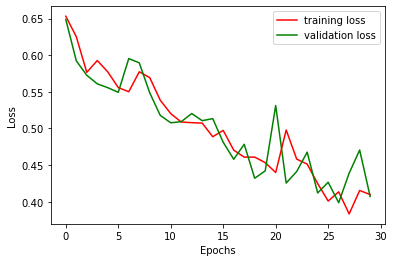

In [23]:
# Plot losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss, color='r', label='training loss')
plt.plot(val_loss, color='g', label='validation loss')
plt.legend()

### 3.3 Evaluate Accuracy
Compare how the model performs on the test dataset:

In [24]:
print('Evaluate model:')
results = model.evaluate(x_test_r, y_test)
print(results)
print('Test loss: {:f}'.format(results[0]))
print('Test accuracy: {:.2f}%'.format(results[1] * 100))

Evaluate model:
15/15 [==============================] - 0s 9ms/step - loss: 0.3818 - acc: 0.8067
[0.381832093000412, 0.8066666722297668]
Test loss: 0.381832
Test accuracy: 80.67%


Accuracy = 80.67%


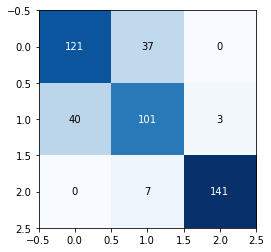

In [25]:
# Plot a confusion matrix
y_pred = model.predict(x_test_r)

y_pred_class_n = np.argmax(y_pred, axis=1)
y_true_class_n = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_class_n, y_pred_class_n)
np.set_printoptions(precision=2)
print("Accuracy = {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(y_true_class_n, y_pred_class_n, labels=[0,1,2])

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.imshow(cm, cmap=plt.cm.Blues)

### 3.4 Save the model
When saving the model in a `.h5` file format, the X-CUBE-AI tool can import the pre-trained model and generate an equivalent C model optmized for STM32 devices.

In [ ]:
# Save the model into an HDF5 file ‘model.h5’
model.save('wmc.h5')